## Programming Exercise 5 - Regularized Linear Regression and Bias v.s. Variance

In [1]:
# %load ../../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
data = loadmat('data/ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data['yval']
Xval = np.c_[np.ones_like(data['Xval']), data['Xval']]


print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Xval:', Xval.shape)
print('yval:', yval.shape)

X_train: (12, 2)
y_train: (12, 1)
Xval: (21, 2)
yval: (21, 1)


### Regularized Linear Regression

(0.0, 38.621190087960144)

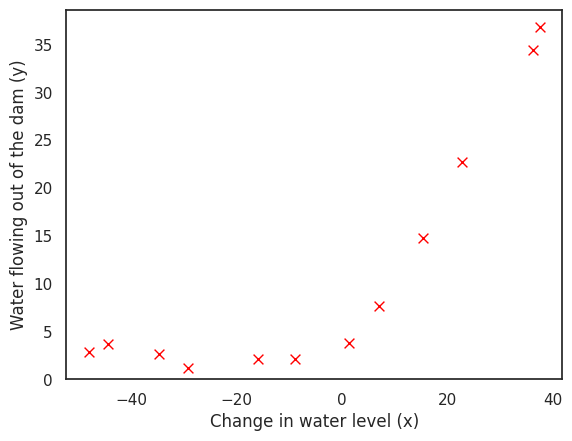

In [4]:
plt.scatter(X_train[:, 1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=0)

#### Regularized Cost function

In [5]:
def linearRegCostFunction(theta, X, y, reg):
    m = y.size
    h = X.dot(theta)
    J = (1 / (2 * m)) * np.sum(np.square(h - y)) + (reg / (2 * m)) * np.sum(np.square(theta[1:]))
    return (J)

#### Gradient

In [6]:
def lrgradientReg(theta, X, y, reg):
    m = y.size   
    h = X.dot(theta.reshape(-1, 1))
    grad = (1 / m) * (X.T.dot(h - y)) + (reg / m) * np.r_[[[0]],theta[1:].reshape(-1, 1)]
    return (grad.flatten())

In [11]:
initial_theta = np.ones((X_train.shape[1], 1))
cost = linearRegCostFunction(initial_theta, X_train, y_train, 0)
gradient = lrgradientReg(initial_theta, X_train, y_train, 0)
print(cost)
print(gradient)

303.9515255535976
[-15.30301567 598.16741084]


In [22]:
def trainLinearReg(X, y, reg):
    initial_theta = np.ones(X.shape[1])
    # initial_theta = np.array([[15],[15]])
    # For some reason the minimize() function does not converge when using zeros as initial theta.
    res = minimize(linearRegCostFunction, initial_theta, args=(X, y, reg), method=None, jac=lrgradientReg,
                   options={'maxiter':5000})
    return (res)

In [23]:
fit = trainLinearReg(X_train, y_train, 0)
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1285.0884851841531
        x: [ 8.757e+00  2.333e-01]
      nit: 3
      jac: [-3.647e+00 -9.212e+01]
 hess_inv: [[ 1.027e+00  6.341e-03]
            [ 6.341e-03  1.209e-03]]
     nfev: 62
     njev: 50

#### Comparison: coefficients and cost obtained with LinearRegression in Scikit-learn

In [24]:
regr = LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train.ravel())
print(regr.coef_)
print(linearRegCostFunction(regr.coef_, X_train, y_train, 0))

[13.08790351  0.36777923]
1604.4002999211034


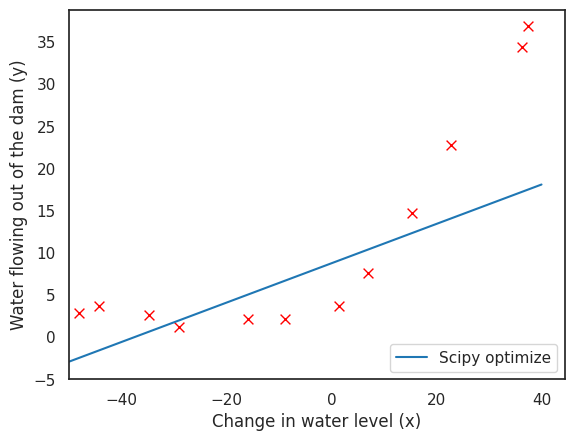

In [25]:
plt.plot(np.linspace(-50, 40), (fit.x[0] + (fit.x[1] * np.linspace(-50, 40))), label='Scipy optimize')
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4)

In [26]:
def learningCurve(X, y, Xval, yval, reg):
    m = y.size
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    for i in np.arange(m):
        res = trainLinearReg(X[:i+1], y[:i+1], reg)
        error_train[i] = linearRegCostFunction(res.x, X[:i+1], y[:i+1], reg)
        error_val[i] = linearRegCostFunction(res.x, Xval, yval, reg)
    return(error_train, error_val)

In [27]:
t_error, v_error = learningCurve(X_train, y_train, Xval, yval, 0)

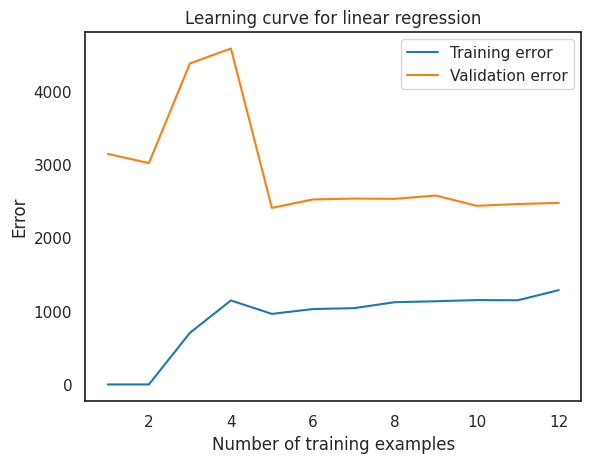

In [28]:
plt.plot(np.arange(1, 13), t_error, label='Training error')
plt.plot(np.arange(1, 13), v_error, label='Validation error')
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

### Polynomial regression (Scikit-learn)

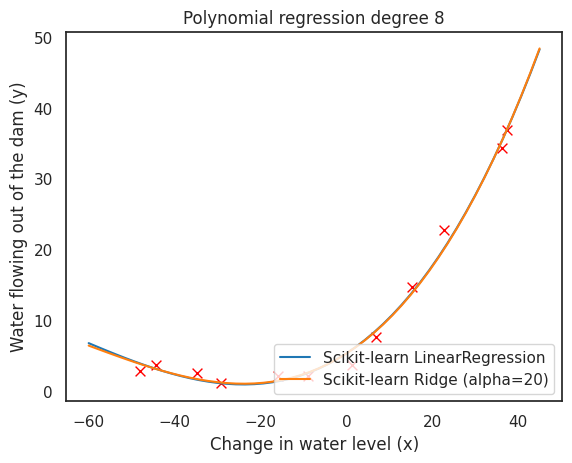

In [30]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train[:, 1].reshape(-1, 1))

regr2 = LinearRegression()
regr2.fit(X_train_poly, y_train)

regr3 = Ridge(alpha=20)
regr3.fit(X_train_poly, y_train)

# plot range for x
plot_x = np.linspace(-60, 45)
# using coefficients to calculate y
plot_y = regr2.intercept_ + np.sum(regr2.coef_ * poly.fit_transform(plot_x.reshape(-1, 1)), axis=1)
plot_y2 = regr3.intercept_ + np.sum(regr3.coef_ * poly.fit_transform(plot_x.reshape(-1, 1)), axis=1)

plt.plot(plot_x, plot_y, label='Scikit-learn LinearRegression')
plt.plot(plot_x, plot_y2, label='Scikit-learn Ridge (alpha={})'.format(regr3.alpha))
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial regression degree 8')
plt.legend(loc=4);